### Setup

In [52]:
import os, sys
HOME = os.environ['HOME']  # change if necessary
sys.path.append(f'{HOME}/Finite-groups/src')

In [53]:
import torch as t
import numpy as np
from matplotlib import pyplot as plt
import json
from itertools import product
from jaxtyping import Float
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import plotly.graph_objects as go
import copy
import math
from itertools import product
import pandas as pd
from typing import Union
from einops import repeat
from huggingface_hub import snapshot_download
from huggingface_hub.utils import disable_progress_bars


from model import MLP3, MLP4, InstancedModule
from utils import *
from group_data import *
from model_utils import *
from group_utils import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [300]:
device = t.device("cuda" if t.cuda.is_available() else "cpu")
# MODEL_DIR = '2024-08-16_22-53-29_SL2_5_MLP3_256'
# MODEL_DIR = '2024-08-14_21-24-30_gapS_5_'
# MODEL_DIR = '2024-08-27_16-32-46_Dic30_MLP3_128'
# MODEL_DIR = '2024-08-27_23-16-05_F11_MLP3_256'
MODEL_DIR = '2024-09-02_18-17-20_smallgrp_54_8_MLP3_256_0_6'
# MODEL_DIR = '2024-09-02_18-51-29_smallgrp_96_71_MLP3_256_0_6'
disable_progress_bars()
local_dir = f'{HOME}/models/{MODEL_DIR}'
if not os.path.exists(local_dir):
    snapshot_download(repo_id=f'wiwu2390/{MODEL_DIR}', local_dir=local_dir)
models, params = load_models(local_dir)
data = GroupData(params)
group = data.groups[0]

Intersection size: 2916/2916 (1.00)
Added 2916 elements from intersection
Added 0 elements from group 0: smallgrp(54,8)
Taking random subset: 1749/2916 (0.60)
Train set size: 1749/2916 (0.60)


/home/wilson/Finite-groups/src/model_utils.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(t.load(model_path, map_location=device))


`models` (returned from `load_models`) is a list of InstancedModule objects, one for each training checkpoint that we chose to save. For most runs, we only save the final checkpoints, so `len(models)==1`

For efficiency during training, the InstancedModule object contains 100 different instances starting from different random initializations. 

Here, we look only at the one with best test accuracy.

In [301]:
loss_dict = test_loss(models[-1].to(device), data)
print(loss_dict['G0_loss'].min(), loss_dict['G0_loss'].argmin())
instance = loss_dict['G0_loss'].argmin().item()
model = models[-1][instance].to(device)

tensor(0.0173) tensor(94)


`MLP3` architecture is
$$f(z\mid x, y) = W_u(z)\cdot\text{ReLU}[W_h(W_l(x)+W_r(y))]] = \sum_i w_u^i(z) \text{ReLU}[w_l^i(x)+w_r^i(y)]$$
where $w_u^i, w_l^i, w_r^i\in\mathbb{R}^G$ are the columns of $W_u, (W_hW_l)^{\top}, (W_hW_r)^{\top}$ respectively.

In [302]:
COMPLEX = False

# model.get_neurons() folds the linear map into the embeddings
lneurons, rneurons = model.get_neurons()
uneurons = model.unembedding.data.detach()
lneurons, rneurons, uneurons = lneurons.squeeze(0).to('cpu'), rneurons.squeeze(0).to('cpu'), uneurons.squeeze(0).to('cpu').T
if COMPLEX:
    lneurons = t.complex(lneurons, t.zeros_like(lneurons))
    rneurons = t.complex(rneurons, t.zeros_like(rneurons))
    uneurons = t.complex(uneurons, t.zeros_like(uneurons))
# lneurons = t.complex(t.zeros_like(lneurons), lneurons)
# rneurons = t.complex(t.zeros_like(rneurons), rneurons)
# uneurons = t.complex(t.zeros_like(uneurons), uneurons)
lneurons.shape, rneurons.shape, uneurons.shape

(torch.Size([54, 256]), torch.Size([54, 256]), torch.Size([54, 256]))

### Neurons are irrep-sparse

I.e., each neuron is a linear combination of matrix entries of some irrep.

That is, for each $i$, there exists an irrep $\rho_i\colon G\to\text{GL}(\mathbb{R}^d)$ such that, for some $A_i,B_i,C_i$,
$$w_l^i(x) \approx \text{tr}(\rho_i(x) A_i)$$
$$w_r^i(y) \approx \text{tr}(\rho_i(y) B_i)$$
$$w_u^i(z) \approx \text{tr}(\rho_i(z) C_i)$$

(This was first noticed by Chughtai et al.)

**Notation**: 4d-0 is the 1st degree 4 irrep, 4d-1 is the 2nd, etc. Ordering is arbitrary but is consistent between runs (I think)

In [303]:
if COMPLEX:
    irreps = group.get_complex_irreps()
else:
    irreps = group.get_real_irreps(verbose=True)
print(irreps.keys())

Complex irrep 3d-0 -> real irrep 6d-0
Complex irrep 3d-1 -> real irrep 6d-1
Complex irrep 3d-2 -> real irrep 6d-2
Complex irrep 3d-3 -> real irrep 6d-3
dict_keys(['1d-0', '1d-1', '2d-0', '2d-1', '2d-2', '2d-3', '6d-0', '6d-1', '6d-2', '6d-3'])


In [304]:
# Get orthogonal basis for each irrep
irrep_bases = dict()
for name, irrep in irreps.items():
    irrep = einops.rearrange(irrep, 'N d1 d2 -> N (d1 d2)')
    U, S, V = t.svd(irrep)
    nonzero = S > 1e-5
    irrep_bases[name] = U[:,nonzero]

# Dimension of subspace spanned by each irrep
for k, v in irrep_bases.items():
    print(k, v.shape)

1d-0 torch.Size([54, 1])
1d-1 torch.Size([54, 1])
2d-0 torch.Size([54, 4])
2d-1 torch.Size([54, 4])
2d-2 torch.Size([54, 4])
2d-3 torch.Size([54, 4])
6d-0 torch.Size([54, 18])
6d-1 torch.Size([54, 18])
6d-2 torch.Size([54, 18])
6d-3 torch.Size([54, 18])


In [305]:
# Proportion of variance explained by each irrep, for each neuron
lexpl, rexpl, uexpl = dict(), dict(), dict()

for name, basis in irrep_bases.items():
    lproj = basis.T @ lneurons
    lexpl[name] = (basis.H @ lneurons).norm(dim=0)**2 / (lneurons.norm(dim=0)**2 + 1e-8)
    rexpl[name] = (basis.H @ rneurons).norm(dim=0)**2 / (rneurons.norm(dim=0)**2 + 1e-8)
    uexpl[name] = (basis.H @ uneurons).norm(dim=0)**2 / (uneurons.norm(dim=0)**2 + 1e-8)

lexpl_max, lirrep = t.stack(list(lexpl.values()), dim=0).max(dim=0)

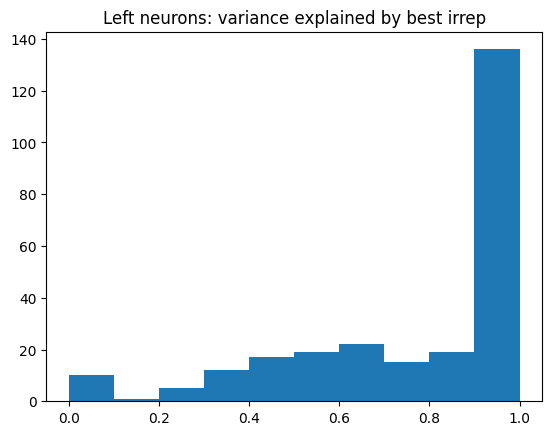

In [306]:
plt.hist(lexpl_max.tolist())
plt.title('Left neurons: variance explained by best irrep')
plt.show()

In [307]:
# Get Frobenius-Schur indicators
# +1 means real irrep. Otherwise, complex.
for name, irrep in irreps.items():
    print(name, group.get_frobenius_schur(irrep))

1d-0 1
1d-1 1
2d-0 1
2d-1 1
2d-2 1
2d-3 1
6d-0 0
6d-1 0
6d-2 0
6d-3 0


In [308]:
irrep_idx_dict = {
    name: [
        i for i in range(lneurons.shape[-1]) 
        if lexpl[name][i].item() > 0.95 and lneurons[:,i].norm() > 1e-4
    ]
    for name in irreps
}
irrep_idx_dict['none'] = {
    i for i in range(lneurons.shape[-1])
    if all(lexpl[name][i].item() <= 0.95 for name in irreps)
}
for k, v in irrep_idx_dict.items():
    print(k, len(v))

1d-0 0
1d-1 2
2d-0 0
2d-1 0
2d-2 11
2d-3 10
6d-0 108
6d-1 0
6d-2 108
6d-3 0
none 125


In [309]:
irrep_name = '6d-0'
irrep_d = irreps[irrep_name].shape[-1]
irrep = irreps[irrep_name]
irrep_idxs = irrep_idx_dict[irrep_name]
irrep_lneurons = lneurons[:, irrep_idxs]
irrep_rneurons = rneurons[:, irrep_idxs]
irrep_uneurons = uneurons[:, irrep_idxs]
irrep_frobschur = np.sign(group.get_frobenius_schur(irrep)).item()

In [310]:
flat_irrep = einops.rearrange(irrep, 'n d1 d2 -> n (d1 d2)')
rcond = t.linalg.matrix_rank(flat_irrep)
# Project neurons onto subspace spanned by flat_irrep
A_flat = t.linalg.lstsq(flat_irrep, irrep_lneurons, driver='gelsd').solution
B_flat = t.linalg.lstsq(flat_irrep, irrep_rneurons, driver='gelsd').solution
C_flat = t.linalg.lstsq(flat_irrep, irrep_uneurons, driver='gelsd').solution
# A_flat = (t.linalg.inv(flat_irrep.H @ flat_irrep) @ flat_irrep.H @ irrep_lneurons)
# B_flat = (t.linalg.inv(flat_irrep.H @ flat_irrep) @ flat_irrep.H @ irrep_rneurons)
# C_flat = (t.linalg.inv(flat_irrep.H @ flat_irrep) @ flat_irrep.H @ irrep_uneurons)
A = einops.rearrange(A_flat, '(d1 d2) m -> m d1 d2', d1=irrep_d, d2=irrep_d).mH
B = einops.rearrange(B_flat, '(d1 d2) m -> m d1 d2', d1=irrep_d, d2=irrep_d).mH
C = einops.rearrange(C_flat, '(d1 d2) m -> m d1 d2', d1=irrep_d, d2=irrep_d).mH

A_norm = t.linalg.matrix_norm(A)
B_norm = t.linalg.matrix_norm(B)
(A_norm - B_norm).norm()**2 / B_norm.norm()**2
print((A_norm - B_norm).norm()**2 / B_norm.norm()**2)

# Normalize A and B to have unit Frobenius norm
# A = A / A_norm.unsqueeze(1).unsqueeze(1)
# B = B / A_norm.unsqueeze(1).unsqueeze(1)
# C = C * ( (A_norm + B_norm) / 2).unsqueeze(1).unsqueeze(1)

A.shape, B.shape, C.shape

tensor(5.1830e-06)


(torch.Size([108, 6, 6]), torch.Size([108, 6, 6]), torch.Size([108, 6, 6]))

### $C_i\approx B_iA_i$

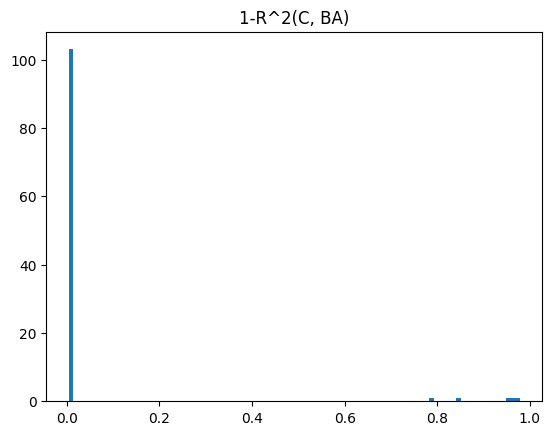

In [311]:
x = einops.rearrange(B @ A, 'm d1 d2 -> m (d1 d2)')
y = einops.rearrange(C, 'm d1 d2 -> m (d1 d2)')
coef = (x.conj() * y).sum(dim=-1) / (x.conj() * x).sum(dim=-1)
yhat = coef.unsqueeze(1) * x
r2 = (yhat - y).norm(dim=-1).pow(2) / y.norm(dim=-1).pow(2)
plt.hist(r2.tolist(), bins=100)
plt.title('1-R^2(C, BA)')
plt.show()
good = r2 < 0.2

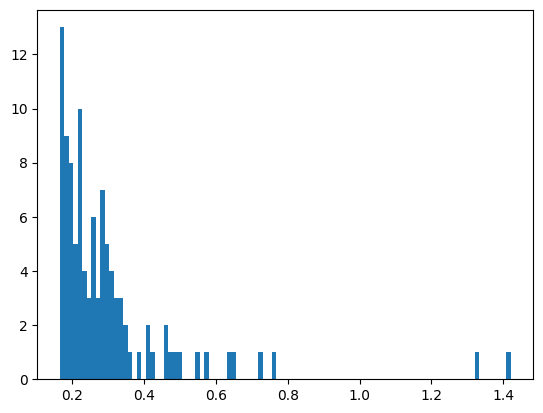

In [312]:
plt.hist(coef[good].tolist(), bins=100)
plt.show()

### $A_i, B_i, C_i$ are low rank

To be specific,
$$
\text{rank}(A)=\text{rank}(B)=\begin{cases}1 & \iota=1 \\ 2 & \iota=0 \\ 4 & \iota=-1,\end{cases}
$$
where $\iota$ is the Frobenius-Schur indicator. (+1 is real irrep, 0 is complex, and -1 is quaternionic.) 

In the real case, we can write
$$A_i\approx a_ib_i^\top$$
$$B_i\approx c_id_i^\top$$
$$C_i\approx A_iB_i\approx \langle b_i, c_i\rangle a_i d_i^\top$$

In [314]:
# a, b, c, d, A_expl, B_expl= [], [], [], [], [], []
rank = {
    1: 1,
    0: 2,
    -1: 4
}[irrep_frobschur]

# Our guess is that left singular vectors of A are const across neurons
# and same for right singular vectors of B (up to sign, etc)
# So we use the first neuron to get the relevant singular vectors
lU0 = t.linalg.svd(A[0])[0]
rV0 = t.linalg.svd(B[0])[2]
lUs, lVs, rUs, rVs = [], [], [], []
for i in range(len(irrep_idxs)):
    lS = t.linalg.svd(A[i])[1]
    rS = t.linalg.svd(B[i])[1]
    lS_inv, rS_inv = t.zeros_like(lS), t.zeros_like(rS)
    lS_inv[:rank] = 1 / lS[:rank]
    rS_inv[:rank] = 1 / rS[:rank]
    lV = t.diag(lS_inv) @ lU0.T @ A[i]
    rU = B[i] @ rV0.T @ t.diag(rS_inv)
    # These asserts check that lV0 are indeed the left singular vectors of A
    # and rU0 are the right singular vectors of B
    assert ((lV @ lV.T)[:rank,:rank] - t.eye(rank)).norm() < 1e-2
    assert ((rU.T @ rU)[:rank,:rank] - t.eye(rank)).norm() < 1e-2
    lUs.append(lU0)
    rUs.append(rU)
    lVs.append(lV)
    rVs.append(rV0)
    # A_expl.append(ls[0]**2 / ls.pow(2).sum())
    # B_expl.append(rs[0]**2 / rs.pow(2).sum())
# a, b, c, d = t.stack(a, dim=0), t.stack(b, dim=0), t.stack(c, dim=0), t.stack(d, dim=0)
rUs = t.stack(rUs, dim=0)
rVs = t.stack(rVs, dim=0)
lUs = t.stack(lUs, dim=0)
lVs = t.stack(lVs, dim=0)
a, b, c, d = lUs[:,:,0], lVs[:,0], rUs[:,:,0], rVs[:,0]
# print(min(A_expl), min(B_expl))

# # Clear up sign ambiguity from SVD
# a_sign = t.sgn(a[:,0])
# a = t.diag(a_sign) @ a
# b = t.diag(a_sign) @ b
# d_sign = t.sgn(d[:,0])
# c = t.diag(d_sign) @ c
# d = t.diag(d_sign) @ d

# # Remove points with bad C=BA r^2
a, b, c, d = a[good], b[good], c[good], d[good]
coef_good = coef[good]

### $a_i,d_i$ are approx. constant and equal

In [315]:
for v in [a, b, c, d]:
    print((v - v.mean(dim=0)).norm()**2 / v.norm()**2)

tensor(7.1054e-15)
tensor(0.9921)
tensor(0.9982)
tensor(6.7763e-21)


In [316]:
(a.mean(dim=0) - d.mean(dim=0)).norm()**2 / a.mean(dim=0).norm()**2

tensor(0.7511)

0 1


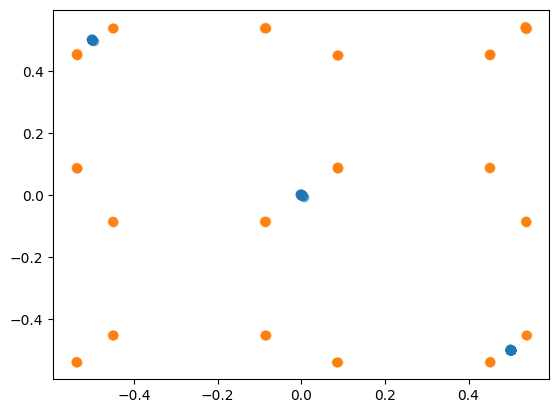

0 2


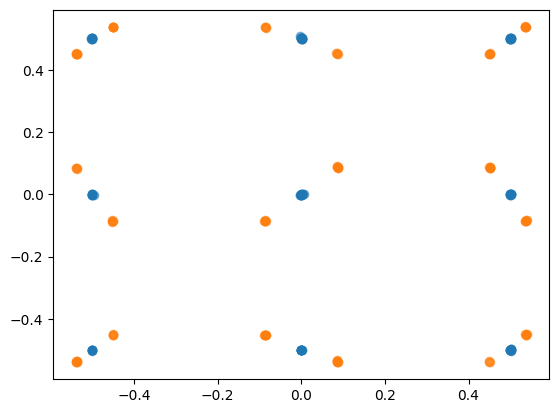

0 3


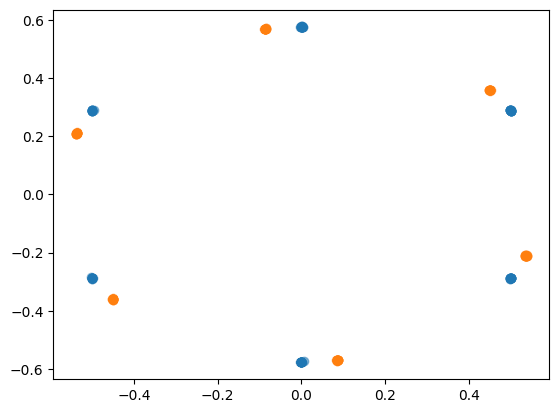

0 4


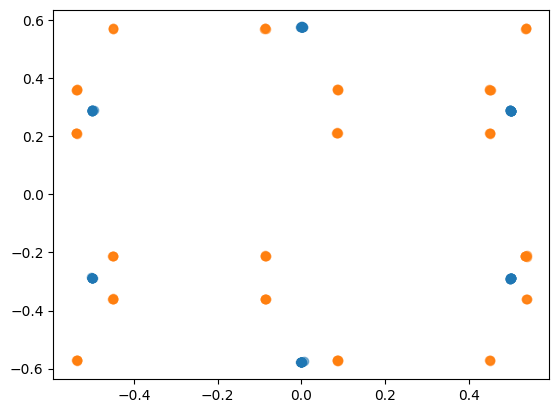

0 5


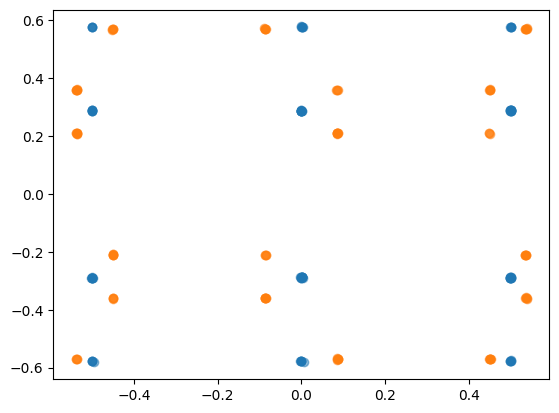

1 2


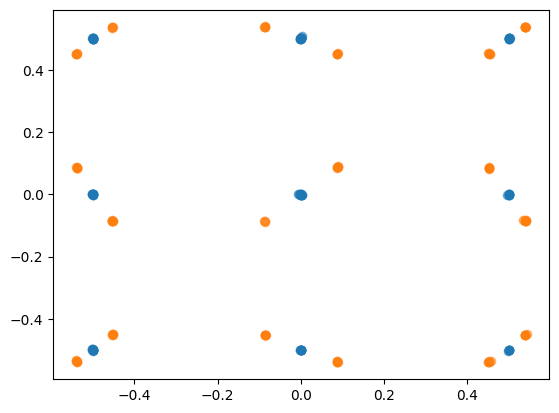

1 3


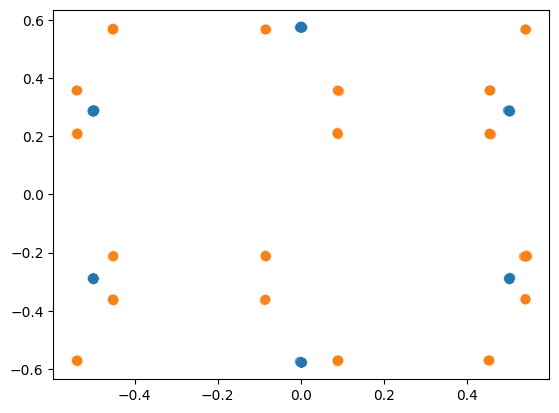

1 4


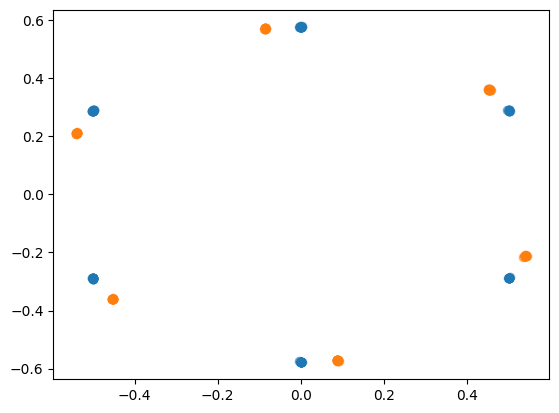

1 5


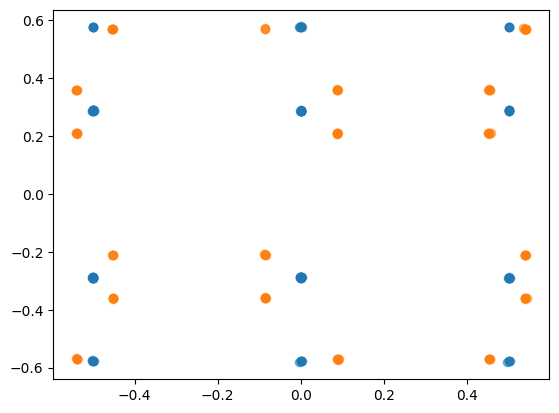

2 3


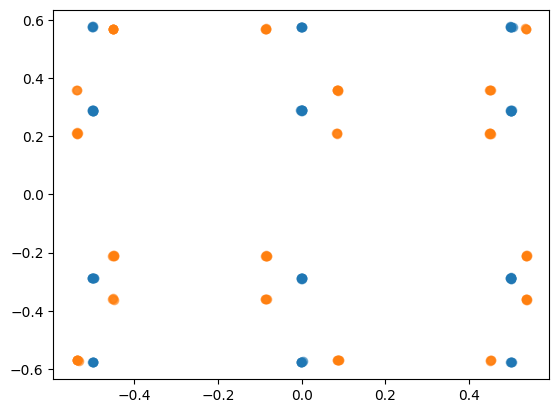

2 4


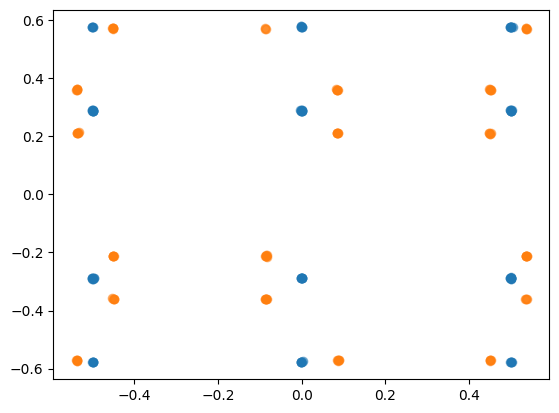

2 5


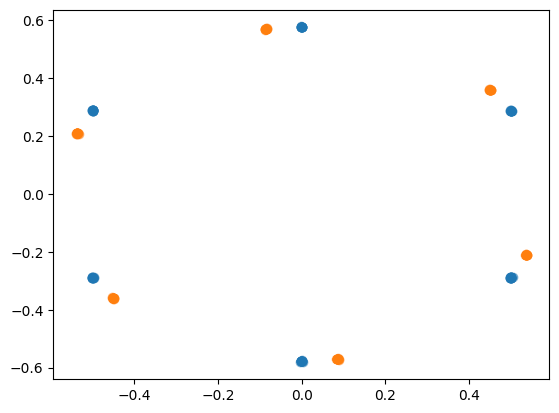

3 4


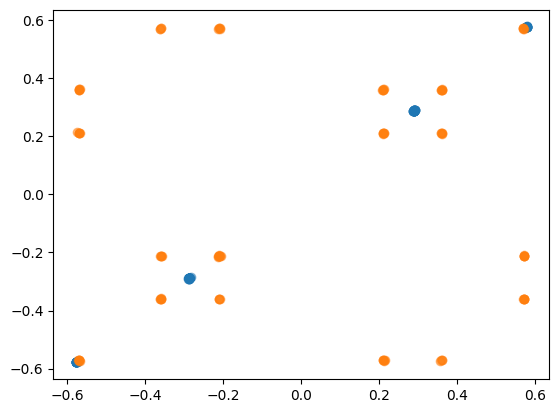

3 5


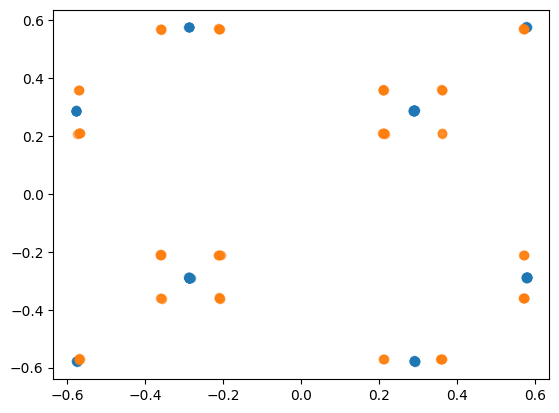

4 5


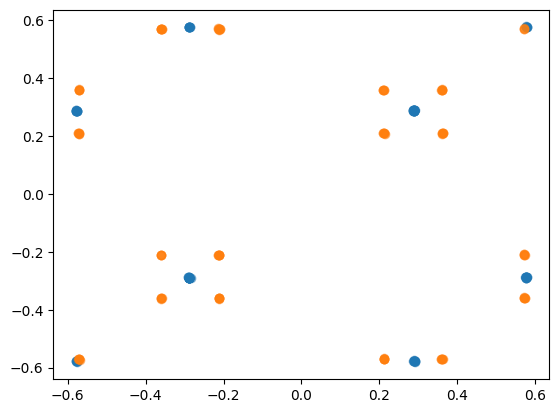

In [317]:
for i, j in product(range(irrep_d), repeat=2):
    if i >= j:
        continue
    print(i, j)
    plt.scatter(b[:,i].tolist(), b[:,j].tolist(), alpha=0.5)
    plt.scatter(c[:,i].tolist(), c[:,j].tolist(), alpha=0.5)
    plt.show()

### b_i and c_i are clustered

In [318]:
b_clusters = 8
c_clusters = 18

from sklearn.cluster import KMeans
c_kmeans = KMeans(n_clusters=c_clusters, random_state=42).fit(c.numpy())
# kmeans.score is negative average squared l2 dist to cluster centroid
print(-c_kmeans.score(c.numpy()) / c.norm()**2)
c_mean = t.tensor(c_kmeans.cluster_centers_)

from sklearn.cluster import KMeans
b_kmeans = KMeans(n_clusters=b_clusters, random_state=42).fit(b.numpy())
# kmeans.score is negative average squared l2 dist to cluster centroid
print(-b_kmeans.score(b.numpy()) / b.norm()**2)
b_mean = t.tensor(b_kmeans.cluster_centers_)


c_labels = c_kmeans.labels_
b_labels = b_kmeans.labels_

tensor(0.2249)
tensor(3.6200e-06)


In [280]:
for i in range(n_clusters):
    print(f'b={i}, c={c_labels[b_labels==i].tolist()}')
    print(f'b={i}, coef={(10*coef_good[b_labels==i]).int().tolist()}')
    print()

b=0, c=[14, 17, 18, 8, 21, 0, 5, 19, 11, 9, 12, 23]
b=0, coef=[1, 1, 1, 1, 3, 1, 1, 1, 5, 1, 1, 1]

b=1, c=[20, 5, 12, 6, 16, 10, 9]
b=1, coef=[1, 1, 1, 1, 1, 1, 1]

b=2, c=[7, 4, 1, 21]
b=2, coef=[1, 1, 1, 4]

b=3, c=[21, 7, 7, 17, 11, 1, 3]
b=3, coef=[2, 10, 1, 1, 5, 1, 3]

b=4, c=[12, 10, 9, 0, 5, 16, 6]
b=4, coef=[1, 1, 1, 1, 1, 1, 1]

b=5, c=[17, 7, 19, 3, 13, 11, 2]
b=5, coef=[1, 1, 1, 1, 1, 1, 1]

b=6, c=[5, 16, 18, 20]
b=6, coef=[1, 2, 1, 1]

b=7, c=[19, 4, 21, 24, 14]
b=7, coef=[1, 1, 2, 3, 1]

b=8, c=[21, 1, 17, 11, 15, 7, 13]
b=8, coef=[2, 1, 1, 3, 4, 1, 3]

b=9, c=[18, 12, 5, 9, 23, 16, 20]
b=9, coef=[1, 1, 1, 1, 1, 1, 1]

b=10, c=[22, 14, 19, 4, 21]
b=10, coef=[7, 1, 1, 1, 3]

b=11, c=[5, 11, 20, 24, 14, 17, 6, 1, 21, 13]
b=11, coef=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

b=12, c=[9, 5, 6, 23, 12, 16, 0]
b=12, coef=[1, 1, 1, 1, 1, 1, 1]

b=13, c=[16, 12, 9, 5, 0, 18, 10]
b=13, coef=[1, 1, 1, 1, 1, 1, 1]

b=14, c=[19, 20, 21, 7, 11, 17, 5, 13, 24, 18]
b=14, coef=[1, 1, 1, 1, 1, 1, 

In [281]:
b_parts = []
c_parts = []
for i in range(n_clusters):
    c_set = set(c_labels[b_labels == i].tolist())
    done = False
    for j in range(len(c_parts)):
        if len(c_set & c_parts[j]) > 0:
            c_parts[j] = c_set.union(c_parts[j])
            b_parts[j].add(i)
            done = True
            break
    if not done:
        c_parts.append(c_set)
        b_parts.append({i})
    print(f'b={i}, c={sorted(c_set)}')

print(b_parts)
print(c_parts)

b_parts = list(map(list, b_parts))
c_parts = list(map(list, c_parts))

b=0, c=[0, 5, 8, 9, 11, 12, 14, 17, 18, 19, 21, 23]
b=1, c=[5, 6, 9, 10, 12, 16, 20]
b=2, c=[1, 4, 7, 21]
b=3, c=[1, 3, 7, 11, 17, 21]
b=4, c=[0, 5, 6, 9, 10, 12, 16]
b=5, c=[2, 3, 7, 11, 13, 17, 19]
b=6, c=[5, 16, 18, 20]
b=7, c=[4, 14, 19, 21, 24]
b=8, c=[1, 7, 11, 13, 15, 17, 21]
b=9, c=[5, 9, 12, 16, 18, 20, 23]
b=10, c=[4, 14, 19, 21, 22]
b=11, c=[1, 5, 6, 11, 13, 14, 17, 20, 21, 24]
b=12, c=[0, 5, 6, 9, 12, 16, 23]
b=13, c=[0, 5, 9, 10, 12, 16, 18]
b=14, c=[5, 7, 11, 13, 17, 18, 19, 20, 21, 24]
b=15, c=[1, 2, 4, 5, 6, 7, 9, 10, 12, 14, 16, 17, 19, 20]
b=16, c=[1, 2, 4, 5, 7, 9, 12, 14, 16, 17, 18, 20, 23]
b=17, c=[5, 8, 9, 10, 12, 18, 20]
b=18, c=[5, 6, 9, 10, 12, 16, 20]
b=19, c=[5, 8, 9, 12, 18, 20, 23]
b=20, c=[2, 3, 7, 11, 13, 17, 19]
b=21, c=[1, 2, 4, 7, 13]
b=22, c=[1, 14, 17, 21]
b=23, c=[0, 5, 6, 8]
b=24, c=[0, 5, 8, 9, 12, 18]
[{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24}]
[{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1

In [265]:
(b_mean[b_parts[0]] @ b_mean[b_parts[0]].T)

tensor([[ 0.1663, -0.0039,  0.0039, -0.1662,  0.0037, -0.0036],
        [-0.0039,  0.1667, -0.1666,  0.0039,  0.1665, -0.1665],
        [ 0.0039, -0.1666,  0.1665, -0.0039, -0.1664,  0.1664],
        [-0.1662,  0.0039, -0.0039,  0.1661, -0.0037,  0.0036],
        [ 0.0037,  0.1665, -0.1664, -0.0037,  0.1667, -0.1667],
        [-0.0036, -0.1665,  0.1664,  0.0036, -0.1667,  0.1667]])

In [267]:
c_mean.shape

torch.Size([8, 12])

In [268]:
(c_mean[c_parts[0]] @ c_mean[c_parts[0]].T)

tensor([[ 0.1666, -0.0004,  0.0004, -0.1665],
        [-0.0004,  0.1663, -0.1665,  0.0002],
        [ 0.0004, -0.1665,  0.1667, -0.0002],
        [-0.1665,  0.0002, -0.0002,  0.1664]])

In [ ]:
(b_mean[b_parts[0]] @ c_mean[c_parts[0]].T)

tensor([[ 0.1004,  0.1003,  0.0995,  0.1003,  0.1001,  0.0982,  0.1001, -1.0000,
          0.1008,  0.1007,  0.0981],
        [ 0.0997,  0.1000, -1.0000,  0.0987,  0.1004,  0.1014,  0.1010,  0.1016,
          0.0986,  0.1001,  0.0998],
        [ 0.0996,  0.1007,  0.0989,  0.0995,  0.0990, -1.0000,  0.1012,  0.0996,
          0.0989,  0.1019,  0.1015],
        [-1.0000,  0.1012,  0.1001,  0.1012,  0.0974,  0.0987,  0.0970,  0.1002,
          0.1012,  0.0994,  0.1002],
        [ 0.0996,  0.0992,  0.1012,  0.0996,  0.0996,  0.1001,  0.0999,  0.0971,
         -1.0000,  0.1002,  0.1008],
        [ 0.1009,  0.1001,  0.0993,  0.1009, -1.0000,  0.1005,  0.0997,  0.0971,
          0.1019,  0.0977,  0.0993],
        [ 0.0994,  0.1008,  0.1014,  0.0991,  0.1003,  0.1000, -1.0000,  0.1010,
          0.0956,  0.1014,  0.0998],
        [ 0.1007, -1.0000,  0.0990,  0.1022,  0.0998,  0.1008,  0.0985,  0.1005,
          0.1012,  0.1012,  0.0990],
        [ 0.1001,  0.0999,  0.1008, -1.0000,  0.1004,  0

In [ ]:
for _ in range(3):
    i = random.choice(range(irrep.shape[0]))
    print(b_mean[b_part2] @ irrep[i] @ b_mean[b_part2].T)
    print(c_mean[c_part2] @ irrep[i].T @ c_mean[c_part2].T)

tensor([[-0.2491, -0.2487, -0.2501, -1.0000,  0.2477],
        [-0.2499, -0.2505, -0.2499,  0.2500,  0.2492],
        [ 1.0000, -0.2497, -0.2495,  0.2506, -1.0000],
        [ 0.2502, -1.0000,  0.2508, -0.2503, -0.2498],
        [ 0.2515,  0.2473,  0.2494,  1.0000, -0.2502]])
tensor([[-0.2499,  0.2504,  1.0000,  0.2505,  0.2482],
        [ 0.2514, -0.2490,  0.2504, -0.2465,  1.0000],
        [-0.2499, -1.0000, -0.2494,  0.2539,  0.2473],
        [-1.0000, -0.2501,  0.2484, -0.2464, -0.2538],
        [ 0.2533, -0.2494,  0.2505,  1.0000, -0.2512]])
tensor([[-0.2500,  1.0000, -0.2494,  0.2503,  0.2497],
        [-0.2495, -0.2496, -0.2499,  0.2513,  0.2488],
        [-0.2492, -0.2502, -0.2499, -1.0000,  0.2479],
        [-1.0000,  0.2496,  0.2511, -0.2492,  1.0000],
        [ 0.2487, -1.0000,  0.2487, -0.2527, -0.2483]])
tensor([[-0.2495,  0.2517, -0.2493, -1.0000,  0.2539],
        [ 0.2490, -0.2490,  0.2521, -0.2472,  1.0000],
        [-0.2509, -1.0000, -0.2497,  0.2527,  0.2473],
       

### Activations are clustered

In [ ]:
embedding_left = model.embedding_left.squeeze(0)
embedding_right = model.embedding_right.squeeze(0)
linear = model.linear.squeeze(0)
unembedding = model.unembedding.squeeze(0).T
# There's a degree of freedom with embedding/unembedding norm.
# Rescale so that each unembedding column is norm 1
u_norm = unembedding.norm(dim=0)
unembedding = unembedding / u_norm
linear = linear * u_norm

In [ ]:
N = len(group)
inputs = t.tensor(list(product(range(N), repeat=2)), device=device)
l_in, r_in = inputs[..., 0], inputs[..., 1]
l_onehot = F.one_hot(l_in, num_classes=N).float()
r_onehot = F.one_hot(r_in, num_classes=N).float()
l_embed = einops.einsum(l_onehot, embedding_left, 'batch group, group embed -> batch embed')
r_embed = einops.einsum(r_onehot, embedding_right, 'batch group, group embed -> batch embed')
l_act = einops.einsum(l_embed, linear, 'batch embed, embed hid -> batch hid')
r_act = einops.einsum(r_embed, linear, 'batch embed, embed hid -> batch hid')
l_act = l_act[:, irrep_idxs]
r_act = r_act[:, irrep_idxs]

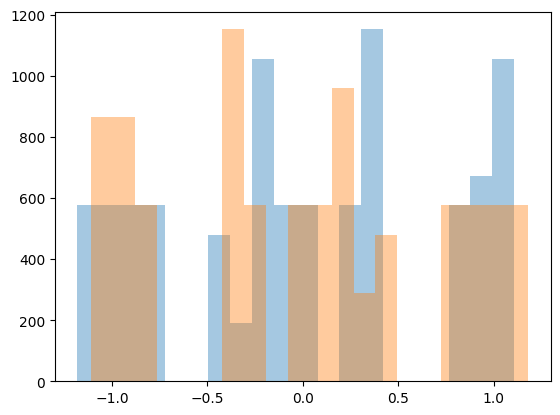

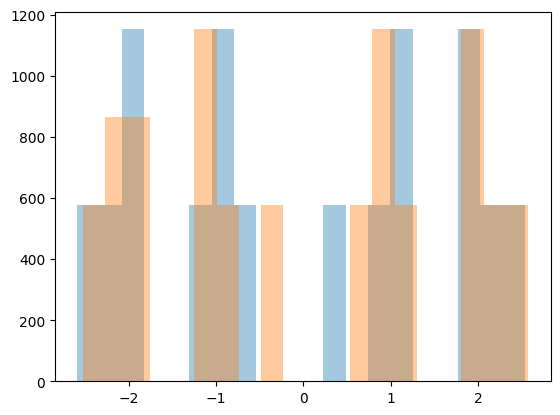

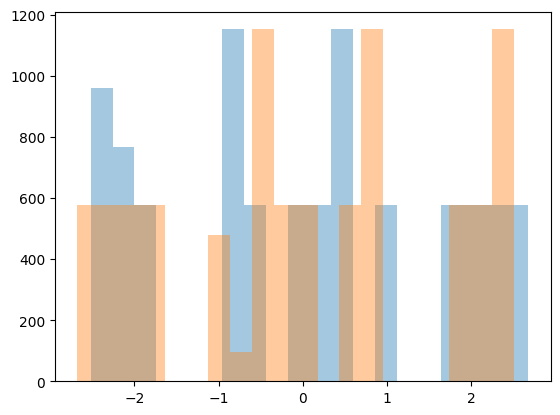

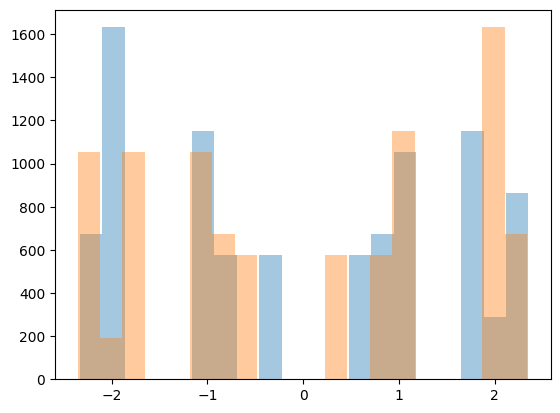

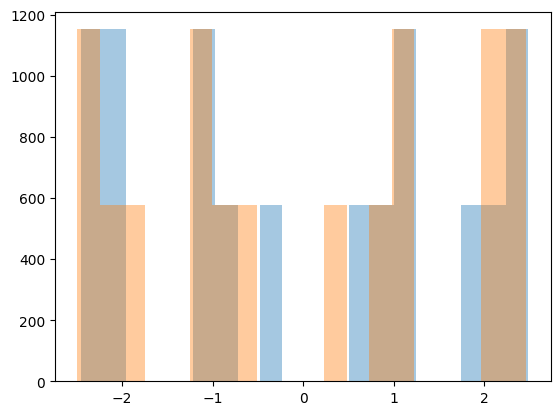

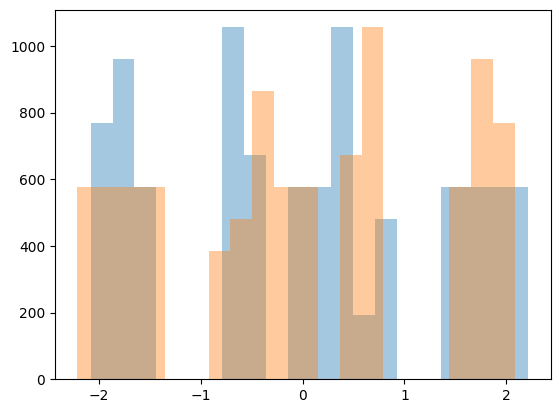

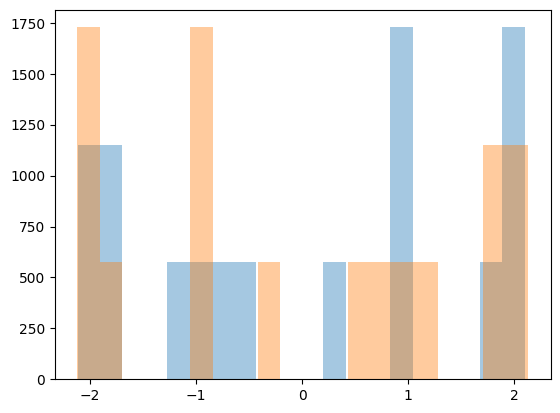

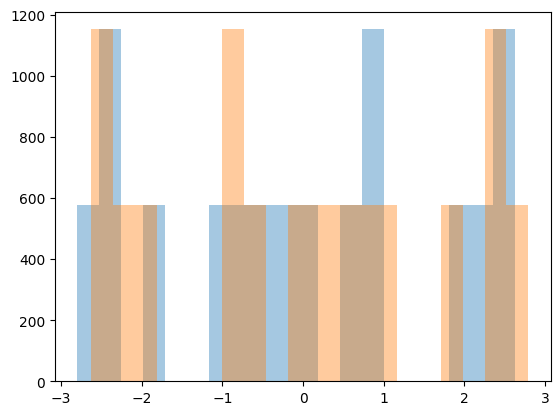

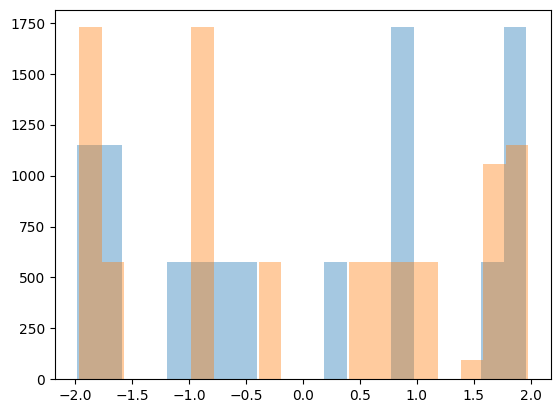

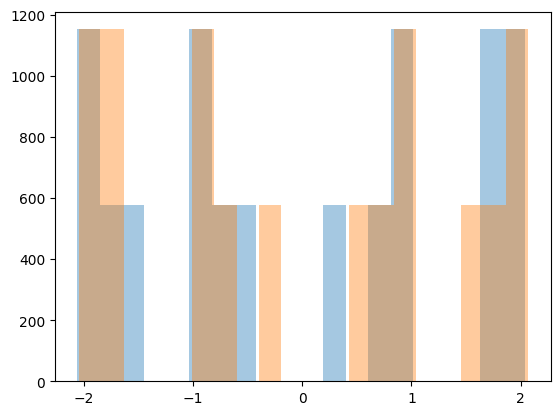

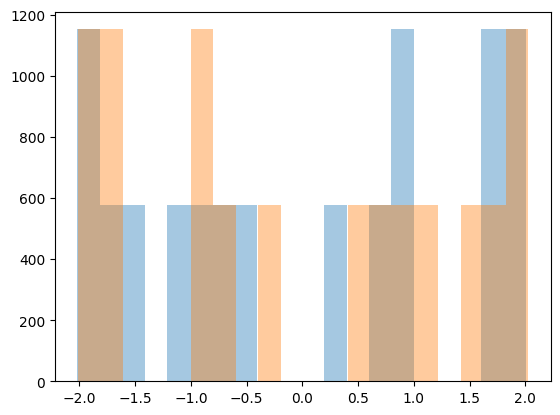

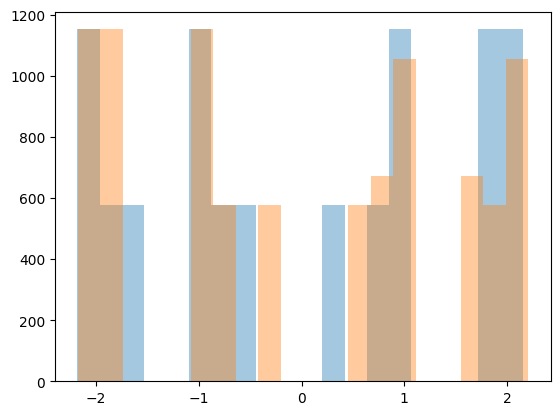

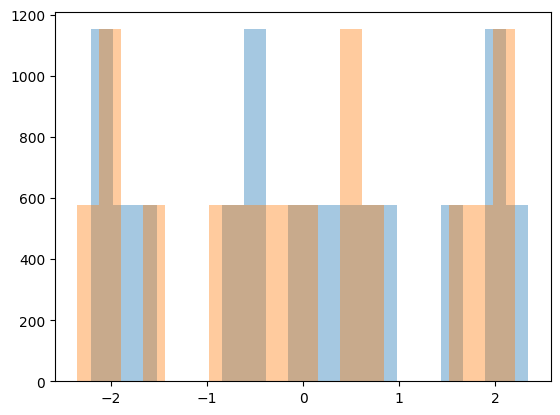

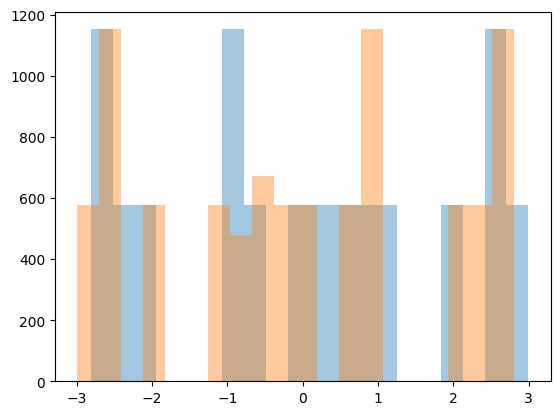

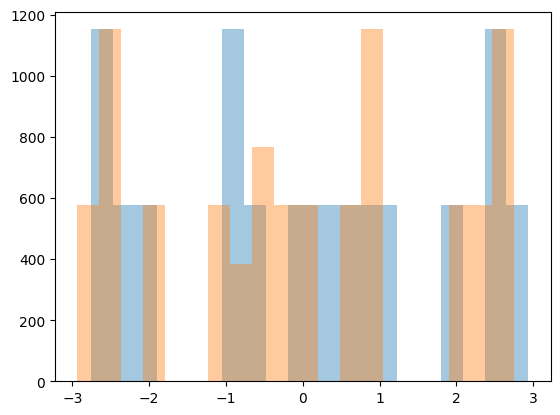

In [ ]:
for i in range(15):
    plt.hist(l_act[:,i].tolist(), alpha=0.4, bins=20)
    plt.hist(r_act[:,i].tolist(), alpha=0.4, bins=20)
    plt.show()

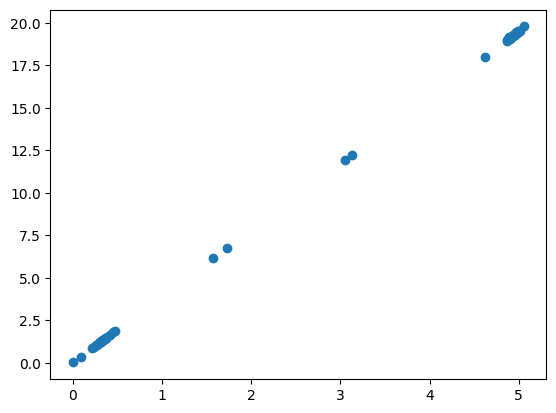

In [ ]:
plt.scatter(coef.tolist(), l_act.max(dim=0)[0].tolist())
plt.show()

In [ ]:
big_neurons = (l_act.max(dim=0)[0] > 15).nonzero()

In [ ]:
b_part1

[0, 1, 3, 4, 9]

In [ ]:
b_labels[big_neurons]

array([[4],
       [5],
       [6],
       [2],
       [6],
       [4],
       [2],
       [6],
       [0],
       [0],
       [6],
       [2],
       [5],
       [5],
       [4],
       [4],
       [2],
       [4],
       [0],
       [5],
       [6],
       [0],
       [0]], dtype=int32)

In [ ]:
def ablate_loss(ln, rn, un):
    ablate_model = copy.deepcopy(model)
    ablate_model.linear.data = t.eye(ln.shape[1]).unsqueeze(0)
    ablate_model.embedding_left.data = ln.unsqueeze(0)
    ablate_model.embedding_right.data = rn.unsqueeze(0)
    ablate_model.unembedding.data = un.unsqueeze(0).mT
    return test_loss(ablate_model.to(device), data)

In [ ]:
big_mask = l_act.max(dim=0)[0] > 15
small_mask = l_act.max(dim=0)[0] < 3
part1_mask = t.tensor([i in b_part1 for i in b_labels], device=device)
part2_mask = t.tensor([i in b_part2 for i in b_labels], device=device)

In [ ]:
print(ablate_loss(irrep_lneurons, irrep_rneurons, irrep_uneurons))
print(ablate_loss(irrep_lneurons[:,big_mask], irrep_rneurons[:,big_mask], irrep_uneurons[:,big_mask]))
print(ablate_loss(irrep_lneurons[:,small_mask], irrep_rneurons[:,small_mask], irrep_uneurons[:,small_mask]))
print(ablate_loss(irrep_lneurons[:,part1_mask], irrep_rneurons[:,part1_mask], irrep_uneurons[:,part1_mask]))
print(ablate_loss(irrep_lneurons[:,part2_mask], irrep_rneurons[:,part2_mask], irrep_uneurons[:,part2_mask]))
print(ablate_loss(irrep_lneurons[:,part1_mask & big_mask], irrep_rneurons[:,part1_mask & big_mask], irrep_uneurons[:,part1_mask & big_mask]))
print(ablate_loss(irrep_lneurons[:,part1_mask & small_mask], irrep_rneurons[:,part1_mask & small_mask], irrep_uneurons[:,part1_mask & small_mask]))
print(ablate_loss(irrep_lneurons[:,part2_mask & big_mask], irrep_rneurons[:,part2_mask & big_mask], irrep_uneurons[:,part2_mask & big_mask]))
print(ablate_loss(irrep_lneurons[:,part2_mask & small_mask], irrep_rneurons[:,part2_mask & small_mask], irrep_uneurons[:,part2_mask & small_mask]))


{'G0_loss': tensor([0.8658]), 'G0_acc': tensor([0.5001])}
{'G0_loss': tensor([1.4867]), 'G0_acc': tensor([0.3433])}
{'G0_loss': tensor([4.2793]), 'G0_acc': tensor([0.3035])}
{'G0_loss': tensor([3.3410]), 'G0_acc': tensor([0.1060])}
{'G0_loss': tensor([2.6429]), 'G0_acc': tensor([0.1717])}
{'G0_loss': tensor([3.5448]), 'G0_acc': tensor([0.0409])}
{'G0_loss': tensor([4.5008]), 'G0_acc': tensor([0.0628])}
{'G0_loss': tensor([3.2302]), 'G0_acc': tensor([0.0570])}
{'G0_loss': tensor([4.5770]), 'G0_acc': tensor([0.0439])}


In [ ]:
ablate_loss(10*irrep_lneurons, 10*irrep_rneurons, 10*irrep_uneurons)

{'G0_loss': tensor([29.3090]), 'G0_acc': tensor([0.5001])}

In [ ]:
irrep_lneurons.shape

torch.Size([120, 52])

In [ ]:
big_mask.sum(), small_mask.sum() 

(tensor(23), tensor(25))